In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import math
from typing import List
import numpy as np
import torch

/var/cr05_data/sim_data/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Generate a sample dataset

In [32]:
def generate_dataset(
    vocab_size: int = 50,
    num_examples: int = 1000,
    seed: int = 0,
) -> List[str]:
    """
    Generate a dataset for the associative recall task.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    tokens = torch.arange(vocab_size) + 1
    keys   = tokens[: (vocab_size // 2) - 1]
    values = tokens[((vocab_size // 2) - 1):-1]
    examples = []
    repeated = []
    golds = []
    for _ in range(num_examples):
        shuffled_keys = keys[torch.randperm(len(keys))]
        shuffled_values = values[torch.randperm(len(values))]
        kv_pairs = list(zip(shuffled_keys, shuffled_values))  
        example = kv_pairs[:4*len(kv_pairs) // 8]
        example += kv_pairs[:4*len(kv_pairs) // 8]
        example += kv_pairs[:4*len(kv_pairs) // 8]
        # shuffle example and repeat_pos
        perm = torch.randperm(len(example))
        example = [example[i] for i in perm]
        repeat_pos = []
        repeats = {}
        for i, (k, v) in enumerate(example):
            if int(k) in repeats:
                repeat_pos.append(i)
            repeats[int(k)] = int(v)
        example_tensor = torch.tensor(example).flatten()
        repeat_tensor = [i*2 for i in repeat_pos]
        gold = []
        for i in repeat_tensor:
            gold.append(int(example_tensor[i+1]))
        repeated.append(repeat_tensor)
        examples.append(example_tensor)
        golds.append(gold)
    examples = torch.stack(examples)
    return examples, repeated, golds

vocab_size=10
examples, repeated, golds = generate_dataset(vocab_size=vocab_size)
examples[0], repeated[0], examples[0][repeated[0]], golds[0]

(tensor([2, 9, 2, 9, 2, 9, 1, 5, 1, 5, 1, 5]),
 [2, 4, 8, 10],
 tensor([2, 2, 1, 1]),
 [9, 9, 5, 5])

#### Understanding the Dataset

Example  Input: tensor([2, 9, 2, 9, 2, 9, 1, 5, 1, 5, 1, 5])  
Example Output: tensor([2, 2, 9, 2, 9, 2, 2, 2, 5, 1, 5, 1]) -- you can see this is the output in the very last line of the notebook! 

Each item in the ouput is the 'next-token prediction' given the tokens seen so far. I.e. we are doing causal language modeling.

- When we have the prefix '2 9', we don't really know what the next token prediction should be, so we end up just seeing some random token '2' in the output. 
- When we have the prefix '2 9 2' we know that we've previously seen '9' follow a '2' so you can see that '9' appears in the 3rd spot of the output vector as the next token prediction for prefix '2 9 2'. 

- Later in the sequence, when we have prefix '2, 9, 2, 9, 2, 9, 1', we have no idea what comes after a '1' since we haven't seen that before. So notice the next token prediction is some random token '2'.
- But when we have the prefix '2, 9, 2, 9, 2, 9, 1, 5, 1,', we have seen '5' follow '1' before. In the output vector, we see the '5'! Great!

If you look at the 'Scoring' code we have provided, we are only scoring your solution on positions that correspond to 'repeated_tokens' (like the repeated 2 or repeated 1 we discussed in the bullets above). We are not scoring those 'random token' positions, since the model has no idea what should come in those positions.

#### Embeddings (do not modify)

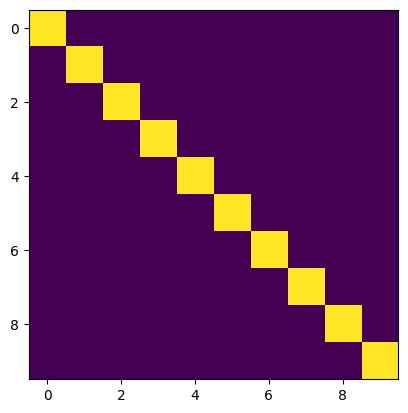

In [33]:
# Define the one-hot token embeddings 
emb_pos_2_tok_id = {}
embeddings_init = torch.zeros(vocab_size, vocab_size)
for i in range(vocab_size):
    embeddings_init[i][i] = 1
    emb_pos_2_tok_id[i] = embeddings_init[i]
plt.imshow(embeddings_init.detach().numpy())

12


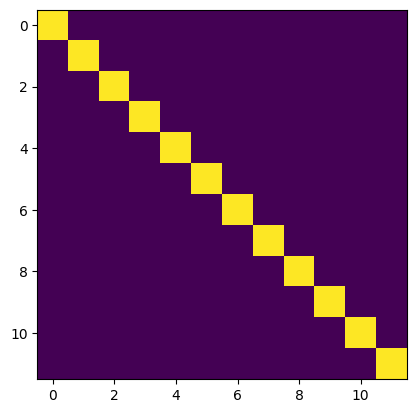

In [34]:
# Define the positional embeddings
batch_size, sequence_length = examples.shape[0], examples.shape[1]
seq_len = sequence_length 
positional_encodings = torch.zeros((seq_len, seq_len))
for pos in range(seq_len):
    positional_encodings[pos][pos] = 1
plt.imshow(positional_encodings.detach().numpy())
print(seq_len)

Sequence length: 12
Model Dimension: 22
Visualizing our input example's embeddings:


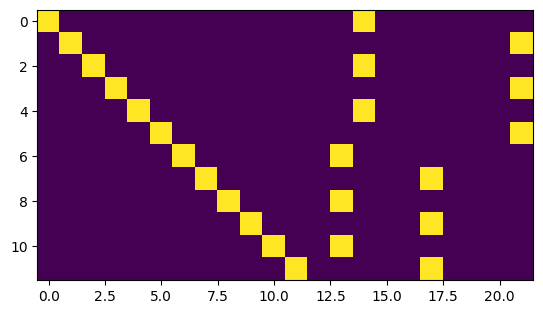

In [35]:
# embed the input
position_dim, embed_dim = positional_encodings.shape[1], embeddings_init.shape[1]
d_model = position_dim + embed_dim 
embs = torch.zeros((batch_size, seq_len, d_model))
# examples = torch.tensor([[0, 1, 3, 4, 5, 6, 0]])
for i in range(len(examples)):
    for j in range(len(examples[i])):
        embs[i][j] = torch.concat((positional_encodings[j], embeddings_init[examples[i][j]]))

print(f"Sequence length: {seq_len}")
print(f"Model Dimension: {d_model}")
print(f"Visualizing our input example's embeddings:")
plt.imshow(embs[0].detach().numpy())

#### Solution -- Your task is to fill in the "YOUR ANSWER" 6 lines of code below!

- For the below code, let $e_i$ represent a token embedding
- Note that we have some "*100" operations to keep the scores we want high after softmax -- softmax makes the distribution spikey

#### Layer 1

In [36]:
# initializing some tensors for Q, K, V (do not modify)
K = torch.eye(d_model) 
Q = torch.zeros_like(K) 
V = torch.zeros_like(K) 

#### TODO Define the weights of the projection matrix K that is used to construct the keys in attention
- Below, we want $q_1k_1^T$ to have high values on positions $p_i$ where $p_{(i-1)}$ was a key token that matches the query token
- The goal of K is to zero-out the token embeddings e1, e2, but keep the position embeddings p1, p2, ...

In [37]:
K[position_dim:] = 0 

#### TODO Define the weights of the projection matrix Q that is used to construct the queries in attention
- The goal of Q is to shift the position embeddings by one position (in addition to masking)

In [38]:
Q[1:position_dim+1, :position_dim] = 100  * # YOUR ANSWER TENSOR

# Hint: YOUR ANSWER should be some tensor that is position_dim x position_dim. The 100 is for the softmax point discussed above (ignore it!)

#### TODO Define the weights of the projection matrix V that is used to construct the values in attention
- The goal of this matrix is to isolate the token embeddings e1, e2, ...
- Ultimately, $output = softmax(q_1 k_1^T)V$ should contain the value of the token embedding that comes after a key token embedding in the original sequence

In [39]:
V[position_dim:, :embed_dim] = 100 * #YOUR ANSWER TENSOR

# Hint: YOUR ANSWER should be some tensor that is embed_dim x embed_dim

In [40]:
# Perform Attention (do not modify)
q1 = embs @ Q 
k1 = embs @ K 
v1 = embs @ V 
S1 = torch.matmul(q1, k1.transpose(1, 2)) / math.sqrt(Q.shape[0])
P1 = torch.nn.functional.softmax(S1, dim=1)
P1 = torch.tril(P1)
O1 = torch.matmul(P1, v1)
z1 = O1 + embs

#### Where are we now?
-  z1 will contain the values corresponding to each key token embedding in the original sequence in the left half of the matrix (e2, e3, e4, ...) (from O1)
- z1 will contain the original token embeddings in the right half of the matrix (e1, e2, e3, ...) (embs)

#### Layer 2: 
Next let's look at layer 2 below. So far, we have the original tokens and the shifted tokens so let's try to rearrange the correct shifted token to be in the output position.

In [41]:
# Initialize (do not modify)
K2 = torch.zeros(d_model, d_model)
Q2 = torch.eye(d_model) 
V2 = torch.eye(d_model)

#### TODO Define the weights of the projection matrix K that is used to construct the keys in attention
- The goal of K is to grab the shifted token embeddings $e_2$, $e_3$, ...

In [42]:
K2[:embed_dim, position_dim:] =  100  * #YOUR ANSWER TENSOR
# Hint: YOUR ANSWER can be filled in with a tensor of dimensions embed_dim x embed dim. Ignore the 100* again (it's to handle the softmax point discussed above)

#### TODO Define the weights of the projection matrix Q that is used to construct the queries in attention
- Q2 will have 1's on the token embedding indices ... so that z1 @ Q2 will yield just the token embeddings $e_1$, $e_2$, ...


In [43]:
Q2[:position_dim] = # YOUR ANSWER SCALAR
# Hint: YOUR ANSWER can be filled in with a single scalar number!

#### TODO Define the weights of the projection matrix V that is used to construct the values in attention
- Now we want q2 (original token embeddings) to match k2 (shifted token embeddings). So $q_2k_2^T$ will have high values on indices that correspond to the desired associative recall outputs
- We want to define V so that it helps us extract the value in the original sequence for $q_2k_2^T$ indices with high values
- Fill in V2 so that v2 will contain the original token embeddings e1, e2, ... after we compute v2 = z1 @ V2

In [44]:
V2[:position_dim] = # YOUR ANSWER SCALAR
# Hint: YOUR ANSWER can be filled in with a single scalar number!

#### The above settings for K2, Q2, and v2 will move the orignal token to the "output" for the next token prediction

In [45]:
# performing attention (do not modify)
q2 = z1 @ Q2
k2 = z1 @ K2
v2 = z1 @ V2
S2 = torch.matmul(q2, k2.transpose(1, 2)) / math.sqrt(Q2.shape[0])
P2 = torch.nn.functional.softmax(S2, dim=1)
P2 = torch.tril(P2)
O2 = torch.matmul(P2, v2)

#### Below, we are going to apply a "language modeling head" to get our next token predictions for the sequence. 

We will do this by taking the argmax of the output O2 --  we are going to take the indices in O2 that have the highest values. Remember that when you trained your model using lm.py in Q1 of the assignment, there was a softmax after all the attention layers and we outputted the token with the highest softmax score. Using argmax is the same idea, except for that because we are using one-hot encodings, the position of the highest value in each row of O2 corresponds to the next-token prediction. We can just take the argmax instead of softmax.

In [52]:
# do not modify
z2 = torch.argmax(O2, dim=-1)

#### Adjusting for concatenated position embeddings. 
Finally, remember that when we constructed our embeddings for the sequence, we had position embeddings concatenated with token embeddings. So let's subtract off the position_dim (number of position embedding spots) so that the token embedding values are correct. 

In [ ]:
# do not modify
z2 = z2 - position_dim

### Score the Results

In [46]:
def score_solution(
    repeated: torch.Tensor, 
    predictions: torch.Tensor,
    golds: torch.Tensor,
) -> float:
    """
    Score a solution to the associative recall task.
    golds is [batch_size x num_golds]
    predictions is [batch_size x sequence_length]
    """
    correct = 0
    total = 0
    incorrect_indices = []
    for idx, (gold, repeat_positions, preds) in enumerate(zip(golds, repeated, predictions)):
        assert len(repeat_positions) == len(gold), print(f"{idx}: {len(repeat_positions)} != {len(gold)} -- repeat: {repeat_positions}, gold: {gold}")
        num_correct = len([True for j, i in enumerate(repeat_positions) if gold[j] == preds[i]])
        correct += num_correct
        total += len(gold)
        if num_correct != len(gold):
            incorrect_indices.append(idx)
    print(f"Accuracy: {correct / total}, sample size {total}, over {len(examples)} examples")
    return incorrect_indices

In [47]:
incorrect_indices = score_solution(repeated, z2, golds)
incorrect_indices[:10]

Accuracy: 1.0, sample size 4000, over 1000 examples


[]

#### Visualize the Steps

Input
tensor([2, 9, 2, 9, 2, 9, 1, 5, 1, 5, 1, 5])
Below we are going to print a bunch of N x D matrices for the solution. Note that D is of length (position_dim + embed_dim)

q1 -- there are ones on the position encodings side of the matrix, shifted by one position


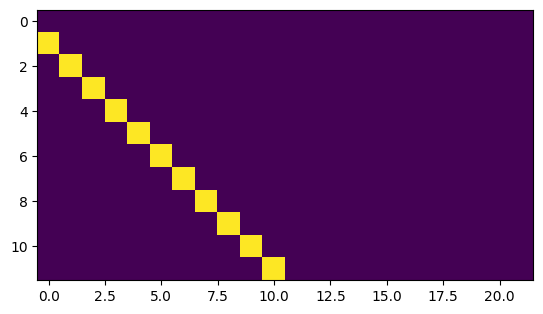

k1 -- there are ones on the position encodings side of the matrix, corresponding to the position encodings in the original sequence


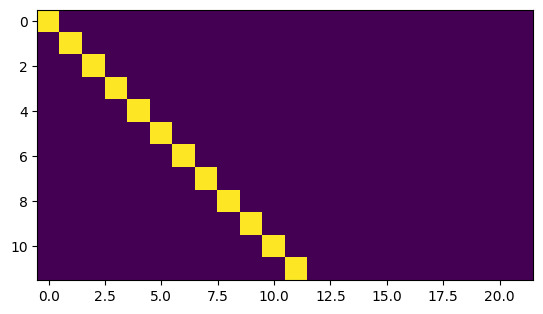

v1 -- we take the original token embeddings in the sequence


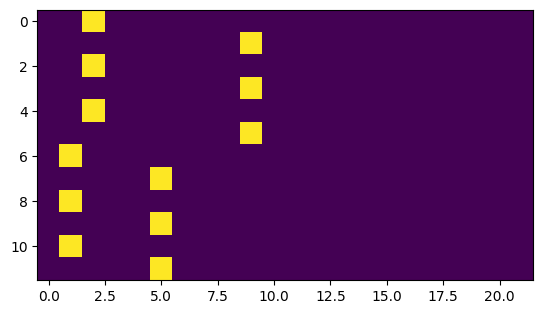

S1 -- there are high values on the indices i, j where j comes before a particular token i in the sequence


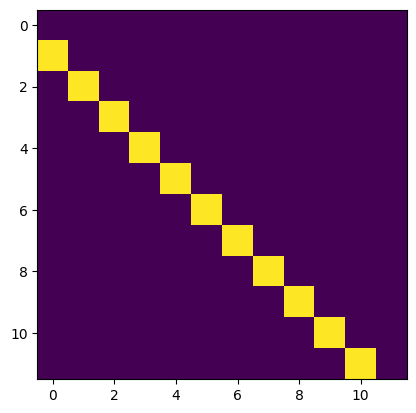

O1 -- we have shifted each token embedding forward by one position. the old token 1 is now at position 2, etc.


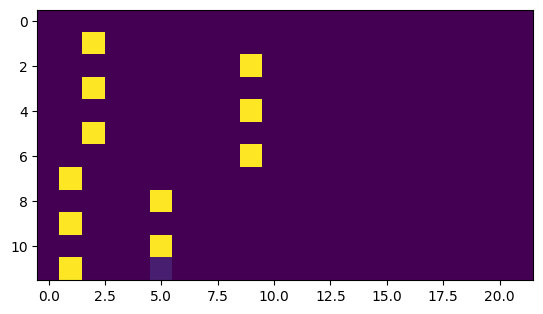

z1 -- it's hard to visualize because of the relative values, but the original embeddings are now added back


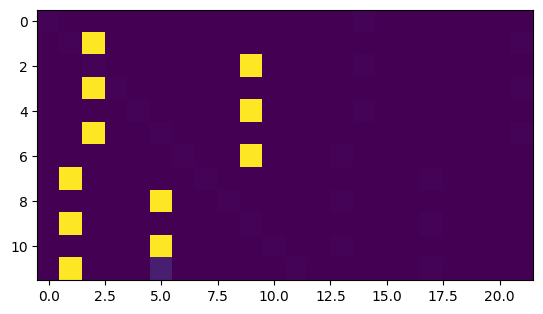

q2 -- remember we said z1 has the original embeddings added back. q2 just takes the original token embeddings from z1 (right hand side)


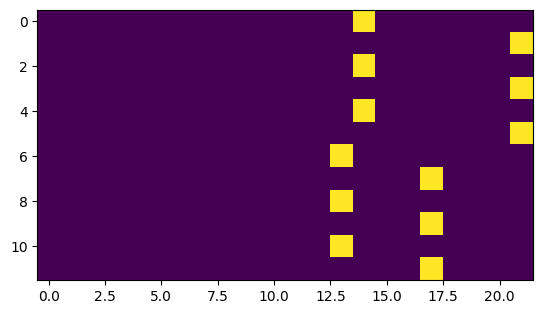

k2 -- k2 takes the embeddings shifted forward by one position (left hand side of z1)


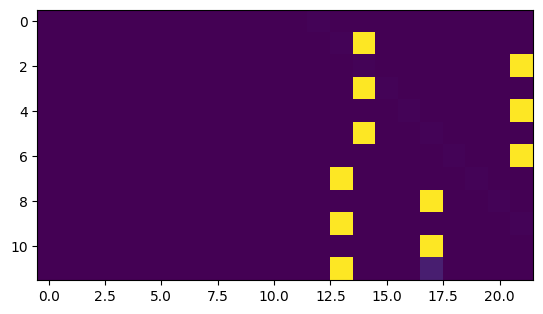

v2 -- v2 takes the original token embeddings from z1 as well


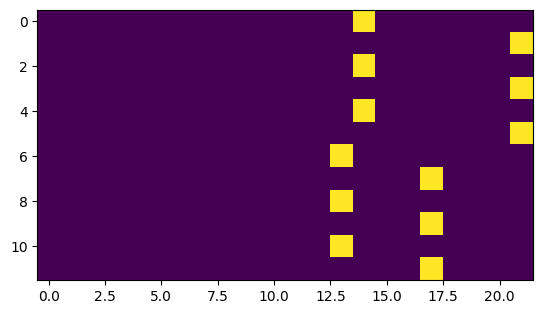

S2 -- S2 has high values at (i, j) if token i matches token j-1 in the original sequence


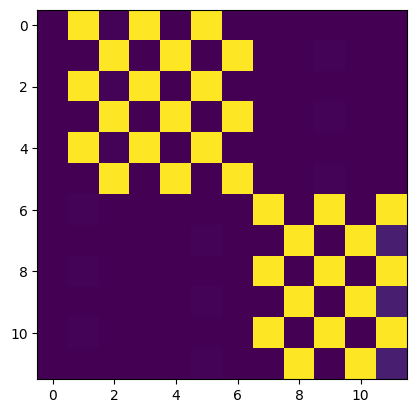

O2 -- O2 has the associative recall output tokens


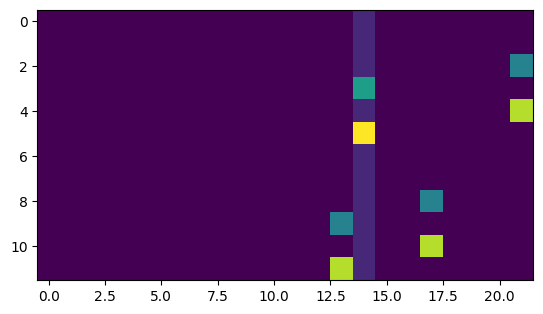

z2 before subtracting position dim -- we take the argmax of O2 to get the token embedding with the 'max' value
tensor([14, 14, 21, 14, 21, 14, 14, 14, 17, 13, 17, 13])
z2 after subtracting position dim (12)
tensor([2, 2, 9, 2, 9, 2, 2, 2, 5, 1, 5, 1])


In [56]:
idx = 0

print("Input")
print(examples[idx])

print(f"Below we are going to print a bunch of N x D matrices for the solution. Note that D is of length (position_dim + embed_dim)\n")

print("q1 -- there are ones on the position encodings side of the matrix, shifted by one position")
plt.imshow(q1[idx].detach().numpy())
plt.show()
print("k1 -- there are ones on the position encodings side of the matrix, corresponding to the position encodings in the original sequence")
plt.imshow(k1[idx].detach().numpy())
plt.show()
print("v1 -- we take the original token embeddings in the sequence")
plt.imshow(v1[idx].detach().numpy())
plt.show()
print("S1 -- there are high values on the indices i, j where j comes before a particular token i in the sequence")
plt.imshow(S1[idx].detach().numpy())
plt.show()
print("O1 -- we have shifted each token embedding forward by one position. the old token 1 is now at position 2, etc.")
plt.imshow(O1[idx].detach().numpy())
plt.show()
print("z1 -- it's hard to visualize because of the relative values, but the original embeddings are now added back")
plt.imshow(z1[idx].detach().numpy())
plt.show()

print("q2 -- remember we said z1 has the original embeddings added back. q2 just takes the original token embeddings from z1 (right hand side)")
plt.imshow(q2[idx].detach().numpy())
plt.show()
print("k2 -- k2 takes the embeddings shifted forward by one position (left hand side of z1)")
plt.imshow(k2[idx].detach().numpy())
plt.show()
print("v2 -- v2 takes the original token embeddings from z1 as well")
plt.imshow(v2[idx].detach().numpy())
plt.show()
print("S2 -- S2 has high values at (i, j) if token i matches token j-1 in the original sequence")
plt.imshow(S2[idx].detach().numpy())
plt.show()
print("O2 -- O2 has the associative recall output tokens")
plt.imshow(O2[idx].detach().numpy())
plt.show()

print("z2 before subtracting position dim -- we take the argmax of O2 to get the token embedding with the 'max' value")
z2 = torch.argmax(O2, dim=-1)
print(z2[0])
print(f"z2 after subtracting position dim ({position_dim})")
z2 = z2 - position_dim
print(z2[0])